# Analysis of different strategies for segmentation

In [1]:
import itertools
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import Normalize
from scipy.spatial import ConvexHull
from scipy.stats import multivariate_normal
from skimage import filters, io

from src.utils.histograms import change_color_space
from src.utils.score_painting_retrieval import score_pixel_masks, score_pixel_mask_list


In [2]:
# Directory containing the images
image_dir = 'data/qsd2_w1'

In [3]:
def get_border_pixel_values(img, border_width=10):
    """
    Get the pixel values of the border of a single channel image
    """

    assert len(img.shape) == 2, "The input image should have a single channel"

    border_pixels = np.concatenate((img[:border_width, :].flatten(),
                                    img[-border_width:, :].flatten(),
                                    img[:, :border_width].flatten(),
                                    img[:, -border_width:].flatten()
                                    ))
    
    return border_pixels

In [4]:
def get_border_mean_std(img, border_width=10):
    """
    Get the mean and standard deviation of the pixel values of the border of a single channel image
    """

    border_pixels = get_border_pixel_values(img, border_width)
    border_mean = np.mean(border_pixels)
    border_std = np.std(border_pixels)

    return border_mean, border_std

In [5]:
def create_histogram(data, bins=256):
    """
    Create a histogram from a list of values and calculate the mean and standard deviation.

    Parameters:
    - data: List or numpy array of values
    - bins: Number of bins for the histogram

    Returns:
    - hist: The values of the histogram
    - bin_edges: The edges of the bins
    - mean: The weighted mean of the data
    - std_dev: The weighted standard deviation of the data
    """
    # Create histogram
    hist, bin_edges = np.histogram(data, bins=bins)

    # Calculate mean and standard deviation using the histogram
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    mean = np.average(bin_centers, weights=hist)
    std_dev = np.sqrt(np.average((bin_centers - mean) ** 2, weights=hist))

    return hist, bin_edges, mean, std_dev

def plot_histogram(hist, bin_edges, mean, std_dev):
    """
    Plot a histogram with lines indicating the mean and standard deviation.

    Parameters:
    - hist: The values of the histogram
    - bin_edges: The edges of the bins
    - mean: The calculated mean of the data
    - std_dev: The calculated standard deviation of the data
    """
    # Get the bin centers for plotting
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot the histogram
    plt.bar(bin_centers, hist, width=np.diff(bin_edges), align='center', alpha=0.6, color='g', label='Histogram')

    # Plot mean and std deviation lines
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2, label='Mean')
    plt.axvline(mean + std_dev, color='b', linestyle='dashed', linewidth=2, label='Mean + Std Dev')
    plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=2, label='Mean - Std Dev')

    # Labels and title
    plt.xlabel('Intensity value')
    plt.ylabel('Frequency')
    plt.title('Pixel intensity histogram')
    plt.legend()
    plt.show()


In [6]:
def generate_masks_for_all_channel_combinations(imgs, bins=[256, 256, 256]):

    all_masks = []

    for img in imgs:

        c1, c2, c3 = cv2.split(img)

        c1_border_values = get_border_pixel_values(c1)
        c2_border_values = get_border_pixel_values(c2)
        c3_border_values = get_border_pixel_values(c3)

        _, _, c1_mean, c1_std_dev = create_histogram(c1_border_values, bins=bins[0])
        _, _, c2_mean, c2_std_dev = create_histogram(c2_border_values, bins=bins[1])
        _, _, c3_mean, c3_std_dev = create_histogram(c3_border_values, bins=bins[2])

        # Define the thresholds based on mean and std dev
        c1_lower = np.floor(c1_mean - c1_std_dev).astype(int)
        c1_upper = np.ceil(c1_mean + c1_std_dev).astype(int)
        c2_lower = np.floor(c2_mean - c2_std_dev).astype(int)
        c2_upper = np.ceil(c2_mean + c2_std_dev).astype(int)
        c3_lower = np.floor(c3_mean - c3_std_dev).astype(int)
        c3_upper = np.ceil(c3_mean + c3_std_dev).astype(int)

        # Create boolean masks for each channel
        c1_mask = (c1 >= c1_lower) & (c1 <= c1_upper)
        c2_mask = (c2 >= c2_lower) & (c2 <= c2_upper)
        c3_mask = (c3 >= c3_lower) & (c3 <= c3_upper)

        # Combine the masks
        c1_c2_c3_mask = np.where(c1_mask & c2_mask & c3_mask, 0, 255)

        c1_c2_mask = np.where(c1_mask & c2_mask, 0, 255)
        c1_c3_mask = np.where(c1_mask & c3_mask, 0, 255)
        c2_c3_mask = np.where(c2_mask & c3_mask, 0, 255)

        c1_mask = np.where(c1_mask, 0, 255)
        c2_mask = np.where(c2_mask, 0, 255)
        c3_mask = np.where(c3_mask, 0, 255)

        all_masks.append([c1_c2_c3_mask, c1_c2_mask, c1_c3_mask, c2_c3_mask, c1_mask, c2_mask, c3_mask])
        
    # Transpose the list of masks so that the masks are grouped by channel
    all_masks = list(map(list, zip(*all_masks)))
    
    return all_masks

#### Histograms using HSV

In [7]:
# List to store the images
hsv_images = []
color_space='HSV'

# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = change_color_space(img, color_space)
        hsv_images.append(img)

In [8]:
hsv_masks_10bins = generate_masks_for_all_channel_combinations(hsv_images, bins=[10, 10, 10])
hsv_masks_50bins = generate_masks_for_all_channel_combinations(hsv_images, bins=[50, 50, 50])
hsv_masks_100bins = generate_masks_for_all_channel_combinations(hsv_images, bins=[100, 100, 100])
hsv_masks_allbins = generate_masks_for_all_channel_combinations(hsv_images, bins=[180, 256, 256]) 

#### Histograms using CIELab

In [9]:
# List to store the images
lab_images = []
color_space='LAB'

# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = change_color_space(img, color_space)
        lab_images.append(img)

In [10]:
lab_masks_10bins = generate_masks_for_all_channel_combinations(lab_images, bins=[10, 10, 10])
lab_masks_50bins = generate_masks_for_all_channel_combinations(lab_images, bins=[50, 50, 50])
lab_masks_100bins = generate_masks_for_all_channel_combinations(lab_images, bins=[100, 100, 100])
lab_masks_allbins = generate_masks_for_all_channel_combinations(lab_images, bins=[256, 256, 256]) 

#### Histograms using RGB

In [11]:
# List to store the images
rgb_images = []
color_space='RGB'

# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = change_color_space(img, color_space)
        rgb_images.append(img)

In [12]:
rgb_masks_10bins = generate_masks_for_all_channel_combinations(rgb_images, bins=[10, 10, 10])
rgb_masks_50bins = generate_masks_for_all_channel_combinations(rgb_images, bins=[50, 50, 50])
rgb_masks_100bins = generate_masks_for_all_channel_combinations(rgb_images, bins=[100, 100, 100])
rgb_masks_allbins = generate_masks_for_all_channel_combinations(rgb_images, bins=[256, 256, 256])

#### Histograms using Grayscale

In [13]:
# List to store the images
gray_images = []
color_space='GRAY'

# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        img = change_color_space(img, color_space)
        gray_images.append(img)

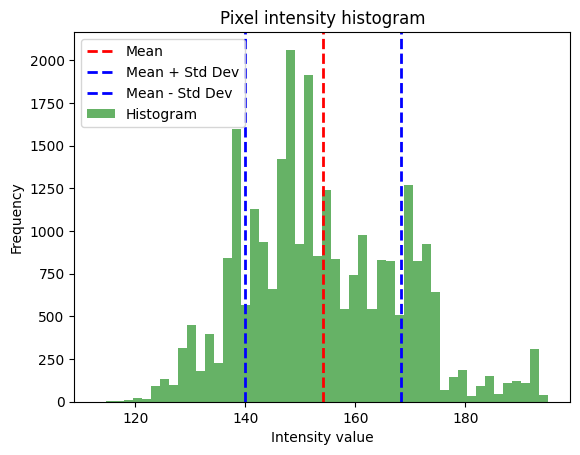

In [14]:
hist, bin_edges, mean, std_dev = create_histogram(get_border_pixel_values(gray_images[10]), bins=50)
plot_histogram(hist, bin_edges, mean, std_dev)

In [15]:
def generate_masks_for_single_channel(imgs, bins=256):

    all_masks = []

    for img in imgs:

        border_values = get_border_pixel_values(img)

        _, _, mean, std_dev = create_histogram(border_values, bins=bins)

        # Define the thresholds based on mean and std dev
        lower = np.floor(mean - std_dev).astype(int)
        upper = np.ceil(mean + std_dev).astype(int)

        # Create boolean masks for each channel
        mask = (img >= lower) & (img <= upper)

        mask = np.where(mask, 0, 255)
        
        # Transpose the list of masks so that the masks are grouped by channel
        all_masks.append(mask)
        
        return all_masks

In [16]:
gray_masks_10bins = generate_masks_for_single_channel(gray_images, bins=10)
gray_masks_50bins = generate_masks_for_single_channel(gray_images, bins=50)
gray_masks_100bins = generate_masks_for_single_channel(gray_images, bins=100)
gray_masks_allbins = generate_masks_for_single_channel(gray_images, bins=256)

#### Extraction of metrics

In [17]:
def performance_accumulation_pixel(pixel_candidates, pixel_annotation):
    """ 
    performance_accumulation_pixel()

    Function to compute different performance indicators 
    (True Positive, False Positive, False Negative, True Negative) 
    at the pixel level
       
    [pixelTP, pixelFP, pixelFN, pixelTN] = performance_accumulation_pixel(pixel_candidates, pixel_annotation)
       
    Parameter name      Value
    --------------      -----
    'pixel_candidates'   Binary image marking the foreground areas
    'pixel_annotation'   Binary image containing ground truth
       
    The function returns the number of True Positive (pixelTP), False Positive (pixelFP), 
    False Negative (pixelFN) and True Negative (pixelTN) pixels in the image pixel_candidates
    """
    
    pixel_candidates = np.uint64(pixel_candidates>0)
    pixel_annotation = np.uint64(pixel_annotation>0)
    
    pixelTP = np.sum(pixel_candidates & pixel_annotation)
    pixelFP = np.sum(pixel_candidates & (pixel_annotation==0))
    pixelFN = np.sum((pixel_candidates==0) & pixel_annotation)
    pixelTN = np.sum((pixel_candidates==0) & (pixel_annotation==0))

    return [pixelTP, pixelFP, pixelFN, pixelTN]


def performance_evaluation_pixel(pixelTP, pixelFP, pixelFN, pixelTN):
    """
    performance_evaluation_pixel()

    Function to compute different performance indicators (Precision, accuracy, 
    specificity, sensitivity) at the pixel level
    
    [pixelPrecision, pixelAccuracy, pixelSpecificity, pixelSensitivity] = PerformanceEvaluationPixel(pixelTP, pixelFP, pixelFN, pixelTN)
    
       Parameter name      Value
       --------------      -----
       'pixelTP'           Number of True  Positive pixels
       'pixelFP'           Number of False Positive pixels
       'pixelFN'           Number of False Negative pixels
       'pixelTN'           Number of True  Negative pixels
    
    The function returns the precision, accuracy, specificity and sensitivity
    """

    pixel_precision   = 0
    pixel_accuracy    = 0
    pixel_specificity = 0
    pixel_sensitivity = 0
    if (pixelTP+pixelFP) != 0:
        pixel_precision   = float(pixelTP) / float(pixelTP+pixelFP)
    if (pixelTP+pixelFP+pixelFN+pixelTN) != 0:
        pixel_accuracy    = float(pixelTP+pixelTN) / float(pixelTP+pixelFP+pixelFN+pixelTN)
    if (pixelTN+pixelFP):
        pixel_specificity = float(pixelTN) / float(pixelTN+pixelFP)
    if (pixelTP+pixelFN) != 0:
        pixel_sensitivity = float(pixelTP) / float(pixelTP+pixelFN)

    return [pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity]


def score_pixel_masks(result_masks, test_masks):
    pixelTP  = 0
    pixelFN  = 0
    pixelFP  = 0
    pixelTN  = 0

    for ii, pixelCandidates in enumerate(result_masks):
        
        # Assume result_masks are already numpy arrays
        if len(pixelCandidates.shape) == 3:  # If it's a color image, take the first channel
            pixelCandidates = pixelCandidates[:, :, 0]
        
        # Accumulate pixel performance of the current image %%%%%%%%%%%%%%%%%
        pixelAnnotation = test_masks[ii]  # The corresponding ground truth mask

        if len(pixelAnnotation.shape) == 3:  # If it's a color image, take the first channel
            pixelAnnotation = pixelAnnotation[:, :, 0]

        # Ensure that the dimensions of the result and ground truth masks match
        if pixelAnnotation.shape != pixelCandidates.shape:
            print(f'Error: hypothesis ({pixelCandidates.shape}) and GT masks ({pixelAnnotation.shape}) dimensions do not match!', file=sys.stderr)
            sys.exit()

        # Evaluate the local pixel performance
        localPixelTP, localPixelFP, localPixelFN, localPixelTN = performance_accumulation_pixel(pixelCandidates > 0, pixelAnnotation > 0)
        
        # Update the total pixel counts
        pixelTP += localPixelTP
        pixelFP += localPixelFP
        pixelFN += localPixelFN
        pixelTN += localPixelTN

    # Calculate pixel-level performance metrics
    pixelPrecision, pixelAccuracy, pixelSpecificity, pixelSensitivity = performance_evaluation_pixel(pixelTP, pixelFP, pixelFN, pixelTN)
    
    # Calculate the F1 score
    pixelF1 = 0
    if (pixelPrecision + pixelSensitivity) != 0:
        pixelF1 = 2 * ((pixelPrecision * pixelSensitivity) / (pixelPrecision + pixelSensitivity))
        
    return pixelPrecision, pixelSensitivity, pixelF1

In [18]:
path = 'data/qsd2_w1'
test_masks = []
for filename in os.listdir(path):
    if filename.endswith('.png'):
        img_path = os.path.join(path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        test_masks.append(img)

In [19]:
# Initialize dictionaries to store f1 scores
hsv_f1_scores = {'10 bins': [], '50 bins': [], '100 bins': [], 'all bins': []}
lab_f1_scores = {'10 bins': [], '50 bins': [], '100 bins': [], 'all bins': []}
rgb_f1_scores = {'10 bins': [], '50 bins': [], '100 bins': [], 'all bins': []}
gray_f1_scores = {'10 bins': [], '50 bins': [], '100 bins': [], 'all bins': []}

# Loop through each mask index
for i in range(7):
    # HSV masks
    print(f'HSV Masks with 10 bins, mask {i+1}')
    _, _, f1_hsv_10 = score_pixel_masks(hsv_masks_10bins[i], test_masks)
    hsv_f1_scores['10 bins'].append(f1_hsv_10)
    
    print(f'HSV Masks with 50 bins, mask {i+1}')
    _, _, f1_hsv_50 = score_pixel_masks(hsv_masks_50bins[i], test_masks)
    hsv_f1_scores['50 bins'].append(f1_hsv_50)
    
    print(f'HSV Masks with 100 bins, mask {i+1}')
    _, _, f1_hsv_100 = score_pixel_masks(hsv_masks_100bins[i], test_masks)
    hsv_f1_scores['100 bins'].append(f1_hsv_100)
    
    print(f'HSV Masks with all bins, mask {i+1}')
    _, _, f1_hsv_all = score_pixel_masks(hsv_masks_allbins[i], test_masks)
    hsv_f1_scores['all bins'].append(f1_hsv_all)

    # LAB masks
    print(f'LAB Masks with 10 bins, mask {i+1}')
    _, _, f1_lab_10 = score_pixel_masks(lab_masks_10bins[i], test_masks)
    lab_f1_scores['10 bins'].append(f1_lab_10)
    
    print(f'LAB Masks with 50 bins, mask {i+1}')
    _, _, f1_lab_50 = score_pixel_masks(lab_masks_50bins[i], test_masks)
    lab_f1_scores['50 bins'].append(f1_lab_50)
    
    print(f'LAB Masks with 100 bins, mask {i+1}')
    _, _, f1_lab_100 = score_pixel_masks(lab_masks_100bins[i], test_masks)
    lab_f1_scores['100 bins'].append(f1_lab_100)
    
    print(f'LAB Masks with all bins, mask {i+1}')
    _, _, f1_lab_all = score_pixel_masks(lab_masks_allbins[i], test_masks)
    lab_f1_scores['all bins'].append(f1_lab_all)

    # RGB masks
    print(f'RGB Masks with 10 bins, mask {i+1}')
    _, _, f1_rgb_10 = score_pixel_masks(rgb_masks_10bins[i], test_masks)
    rgb_f1_scores['10 bins'].append(f1_rgb_10)
    
    print(f'RGB Masks with 50 bins, mask {i+1}')
    _, _, f1_rgb_50 = score_pixel_masks(rgb_masks_50bins[i], test_masks)
    rgb_f1_scores['50 bins'].append(f1_rgb_50)
    
    print(f'RGB Masks with 100 bins, mask {i+1}')
    _, _, f1_rgb_100 = score_pixel_masks(rgb_masks_100bins[i], test_masks)
    rgb_f1_scores['100 bins'].append(f1_rgb_100)
    
    print(f'RGB Masks with all bins, mask {i+1}')
    _, _, f1_rgb_all = score_pixel_masks(rgb_masks_allbins[i], test_masks)
    rgb_f1_scores['all bins'].append(f1_rgb_all)

# Gray masks
print('Gray Masks')
_, _, f1_gray_10 = score_pixel_masks(gray_masks_10bins, test_masks)
gray_f1_scores['10 bins'].append(f1_gray_10)
_, _, f1_gray_50 = score_pixel_masks(gray_masks_50bins, test_masks)
gray_f1_scores['50 bins'].append(f1_gray_50)
_, _, f1_gray_100 = score_pixel_masks(gray_masks_100bins, test_masks)
gray_f1_scores['100 bins'].append(f1_gray_100)
_, _, f1_gray_all = score_pixel_masks(gray_masks_allbins, test_masks)
gray_f1_scores['all bins'].append(f1_gray_all)

HSV Masks with 10 bins, mask 1
HSV Masks with 50 bins, mask 1
HSV Masks with 100 bins, mask 1
HSV Masks with all bins, mask 1
LAB Masks with 10 bins, mask 1
LAB Masks with 50 bins, mask 1
LAB Masks with 100 bins, mask 1
LAB Masks with all bins, mask 1
RGB Masks with 10 bins, mask 1
RGB Masks with 50 bins, mask 1
RGB Masks with 100 bins, mask 1
RGB Masks with all bins, mask 1
HSV Masks with 10 bins, mask 2
HSV Masks with 50 bins, mask 2
HSV Masks with 100 bins, mask 2
HSV Masks with all bins, mask 2
LAB Masks with 10 bins, mask 2
LAB Masks with 50 bins, mask 2
LAB Masks with 100 bins, mask 2
LAB Masks with all bins, mask 2
RGB Masks with 10 bins, mask 2
RGB Masks with 50 bins, mask 2
RGB Masks with 100 bins, mask 2
RGB Masks with all bins, mask 2
HSV Masks with 10 bins, mask 3
HSV Masks with 50 bins, mask 3
HSV Masks with 100 bins, mask 3
HSV Masks with all bins, mask 3
LAB Masks with 10 bins, mask 3
LAB Masks with 50 bins, mask 3
LAB Masks with 100 bins, mask 3
LAB Masks with all bins,

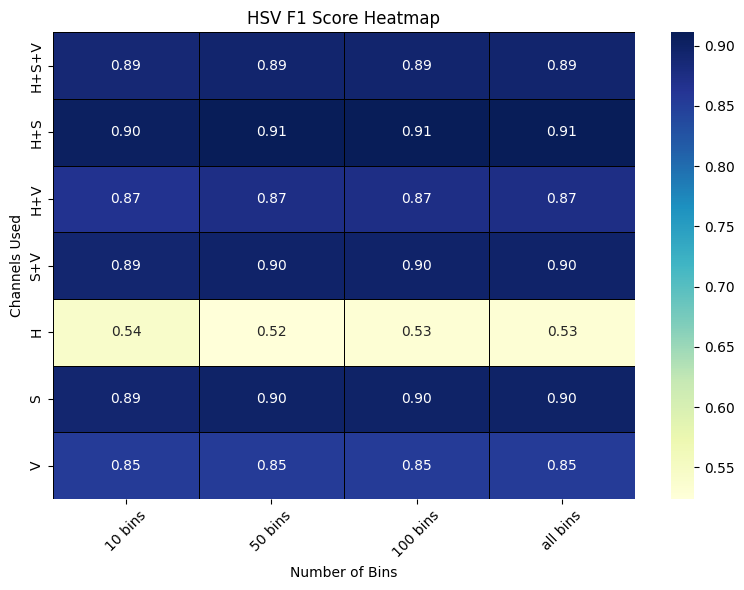

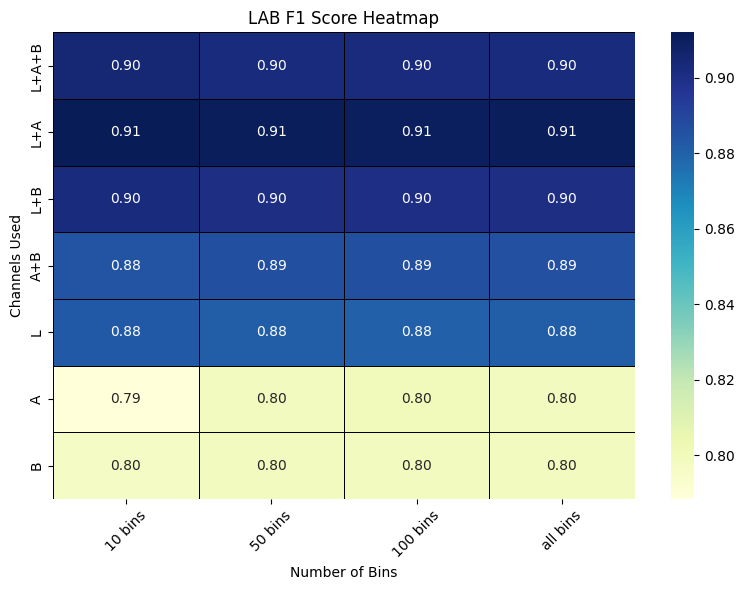

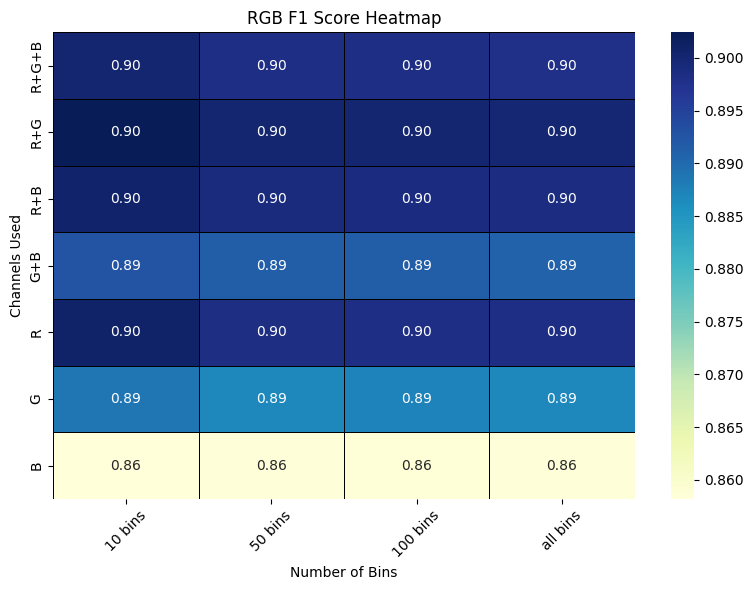

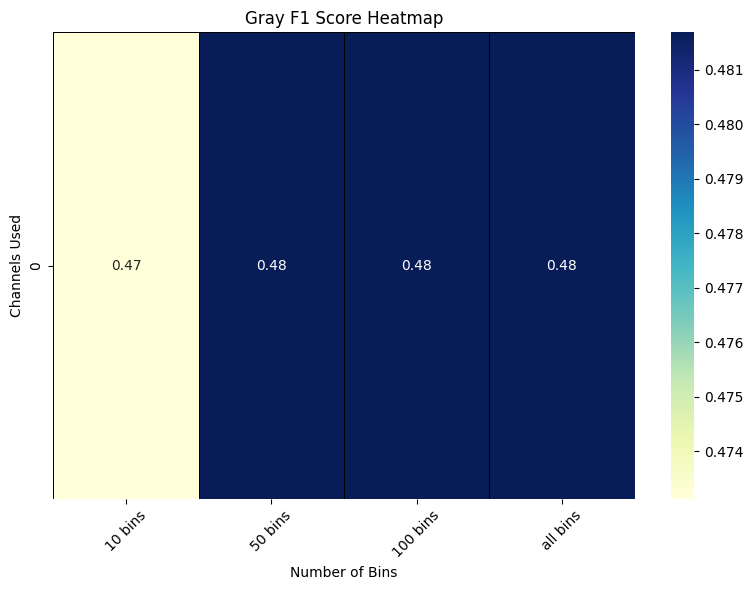

In [20]:
# Convert the f1 score dictionaries to DataFrames
hsv_df = pd.DataFrame(hsv_f1_scores)
lab_df = pd.DataFrame(lab_f1_scores)
rgb_df = pd.DataFrame(rgb_f1_scores)
gray_df = pd.DataFrame(gray_f1_scores)

# Set the row labels
hsv_df.index = ['H+S+V', 'H+S', 'H+V', 'S+V', 'H', 'S', 'V']
lab_df.index = ['L+A+B', 'L+A', 'L+B', 'A+B', 'L', 'A', 'B']
rgb_df.index = ['R+G+B', 'R+G', 'R+B', 'G+B', 'R', 'G', 'B']

# Function to create heatmap
def create_heatmap(dataframe, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(dataframe, annot=True, cmap='YlGnBu', cbar=True, fmt=".2f",
                linewidths=0.5, linecolor='black')
    plt.title(title)
    plt.xlabel('Number of Bins')
    plt.ylabel('Channels Used')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create heatmaps for each color space
create_heatmap(hsv_df, 'HSV F1 Score Heatmap')
create_heatmap(lab_df, 'LAB F1 Score Heatmap')
create_heatmap(rgb_df, 'RGB F1 Score Heatmap')
create_heatmap(gray_df, 'Gray F1 Score Heatmap')

#### Opening Residue

In [21]:
def opening_residue(img, kernel_size=(300, 300), thres=25):

    # Invert the image
    img_neg = cv2.bitwise_not(img)

    # Background: opening; (f o B)
    kernel = np.ones(kernel_size, np.uint8)
    opened = cv2.morphologyEx(img_neg, cv2.MORPH_OPEN, kernel)

    # Residue; f - (f o B)
    residue = cv2.subtract(img_neg, opened)

    # Thresholding
    _, thresholded = cv2.threshold(residue, thres, 255, cv2.THRESH_BINARY)

    return img_neg, opened, residue, thresholded

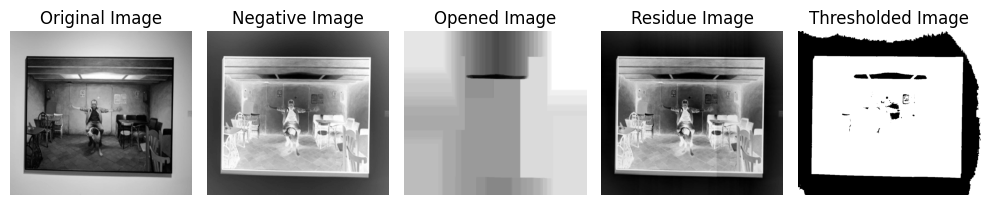

In [22]:
img_neg, opened, residue, thresholded = opening_residue(gray_images[19])

# Plot the images
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(151)
plt.imshow(gray_images[19], cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Negative Image
plt.subplot(152)
plt.imshow(img_neg, cmap='gray')
plt.title('Negative Image')
plt.axis('off')

# Opened Image
plt.subplot(153)
plt.imshow(opened, cmap='gray')
plt.title('Opened Image')
plt.axis('off')

# Residue Image
plt.subplot(154)
plt.imshow(residue, cmap='gray')
plt.title('Residue Image')
plt.axis('off')

# Thresholded Image
plt.subplot(155)
plt.imshow(thresholded, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')

plt.tight_layout()
plt.show()


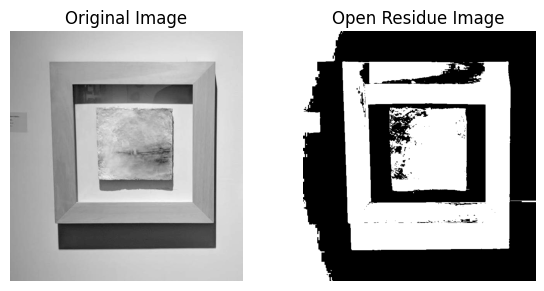

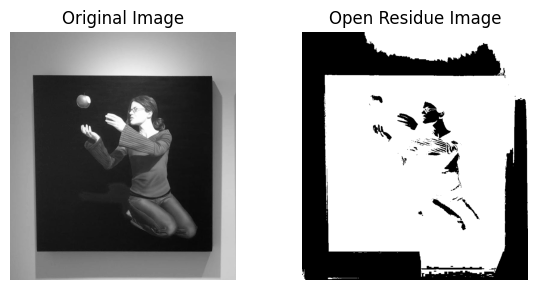

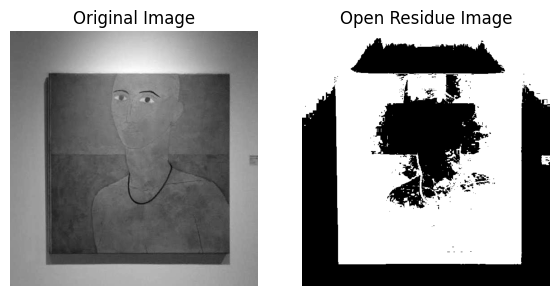

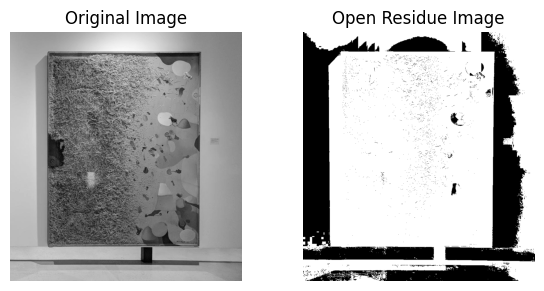

In [23]:
opening_residue_masks = []

for img in gray_images[:4]:

    _, _, _, residue = opening_residue(img)
    opening_residue_masks.append(residue)
    
    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(residue, cmap='gray')
    plt.title('Open Residue Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

#### Adaptive Threshold

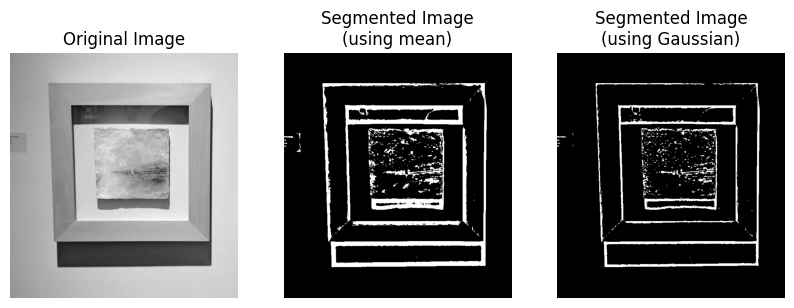

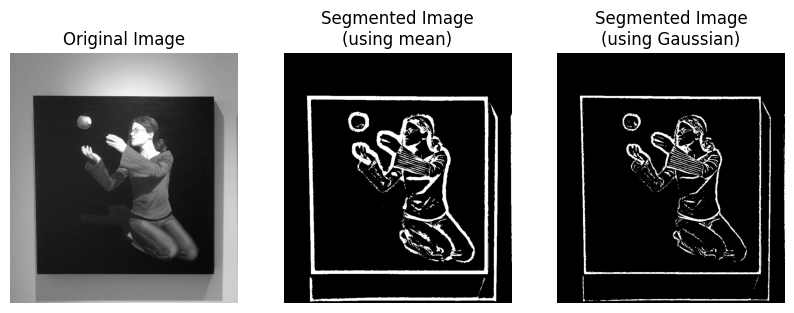

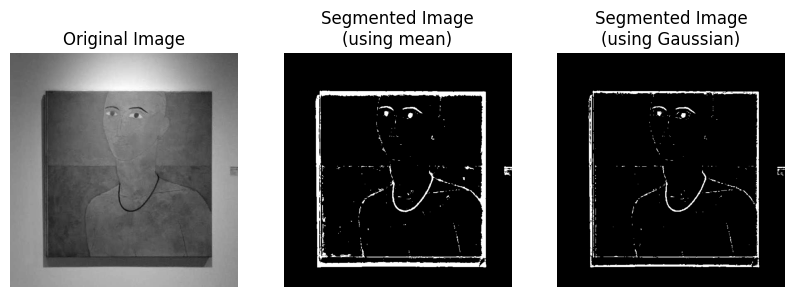

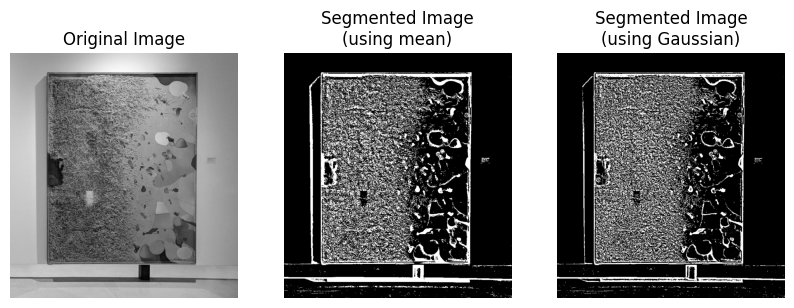

In [24]:
adaptive_threshold_mean_masks = []
adaptive_threshold_gaussian_masks = []

for img in gray_images[:4]:

    # Adaptive threshold using mean
    mean_threshold = cv2.adaptiveThreshold(
        img,
        255,  # Maximum value
        cv2.ADAPTIVE_THRESH_MEAN_C,  # Adaptive thresholding method
        cv2.THRESH_BINARY,  # Threshold type
        29,  # Neighborhood size (must be odd)
        8  # Constant subtracted from the mean
    )

    # Adaptive threshold using Gaussian
    gaussian_threshold = cv2.adaptiveThreshold(
        img,
        255,  # Maximum value
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Adaptive thresholding method
        cv2.THRESH_BINARY,  # Threshold type
        29,  # Neighborhood size (must be odd)
        8  # Constant subtracted from the mean
    )

    # Negative of the obtained image
    neg_mean = cv2.bitwise_not(mean_threshold)
    neg_gaussian = cv2.bitwise_not(gaussian_threshold)

    adaptive_threshold_mean_masks.append(neg_mean)
    adaptive_threshold_gaussian_masks.append(neg_gaussian)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(neg_mean, cmap='gray')
    plt.title(f'Segmented Image\n(using mean)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(neg_gaussian, cmap='gray')
    plt.title(f'Segmented Image\n(using Gaussian)')
    plt.axis('off')

    plt.show()

#### Otsu's Threshold

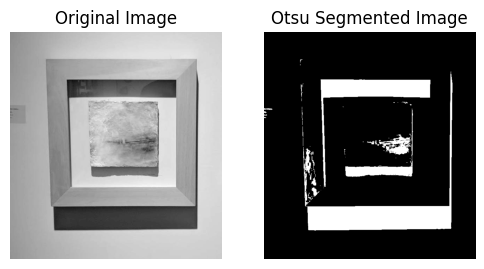

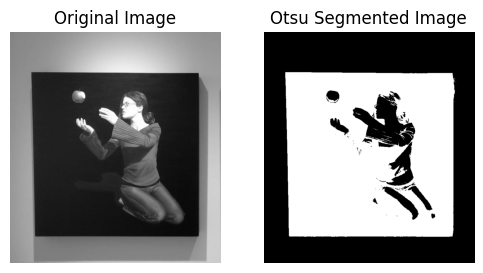

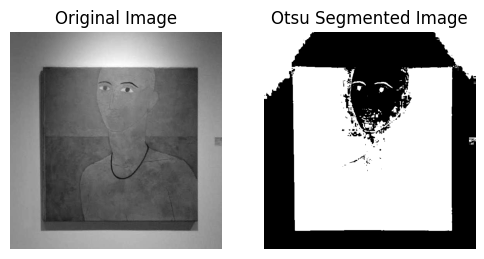

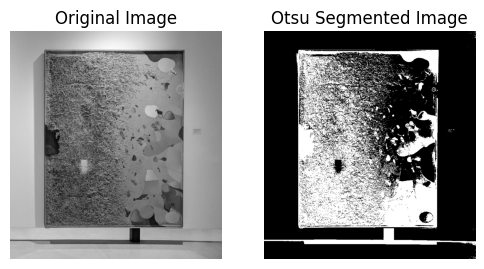

In [25]:
otsu_threshold_masks = []

for img in gray_images[:4]:

    # Otsu's threshold
    otsu_segmented = img < (otsu_threshold := filters.threshold_otsu(img))

    otsu_threshold_masks.append(otsu_segmented)

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(otsu_segmented, cmap='gray')
    plt.title(f'Otsu Segmented Image')
    plt.axis('off')

    plt.show()

In [26]:
def biased_otsu_thresholding(img):

    blur = cv2.GaussianBlur(img, (5, 5), 0)

    # Find normalized histogram and its cumulative distribution function
    hist = cv2.calcHist([blur], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()
    Q = hist_norm.cumsum()
    bins = np.arange(256)

    # Imposed background statistics (mean and standard deviation)
    mean_bg, std_bg = get_border_mean_std(blur)

    fn_min = np.inf
    thresh = -1

    for i in range(1, 256):
        p1, p2 = np.hsplit(hist_norm, [i])  # probabilities
        q1, q2 = Q[i], Q[255] - Q[i]        # cumulative sums

        if q1 < 1.e-6 or q2 < 1.e-6:
            continue

        b1, b2 = np.hsplit(bins, [i])  # weights
        # Finding means
        m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2

        # Calculate variances
        v1 = np.sum(((b1 - m1) ** 2) * p1) / q1
        v2 = np.sum(((b2 - m2) ** 2) * p2) / q2

        # Background standard deviation
        std_bg_estimated = np.sqrt(v1)

        # Apply a penalty to enforce the background statistics to match the imposed mean and std
        mean_diff = (m1 - mean_bg) ** 2  # squared difference between background means
        std_diff = (std_bg_estimated - std_bg) ** 2  # squared difference between background stds

        # Control the weight of mean and std differences in the penalty
        penalty = 0.5 * mean_diff + 0.5 * std_diff  # Adjust the weights if needed

        # Modified cost function: within-class variance for both classes + penalty for background mismatch
        fn = (v1 * q1 + v2 * q2) + penalty

        if fn < fn_min:
            fn_min = fn
            thresh = i

    return img < thresh


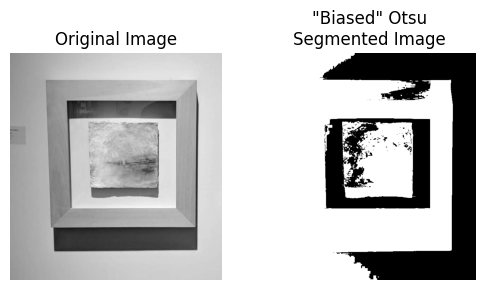

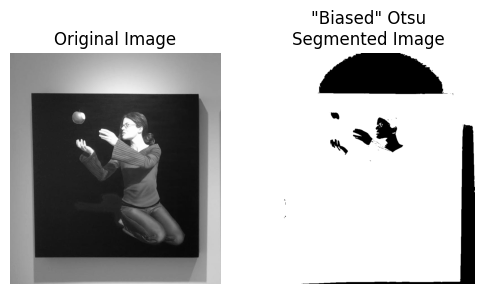

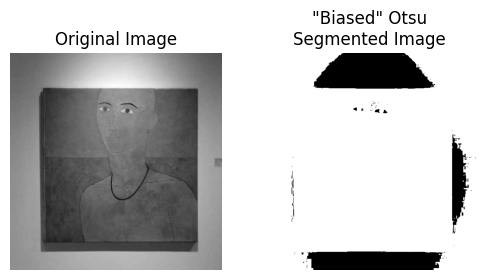

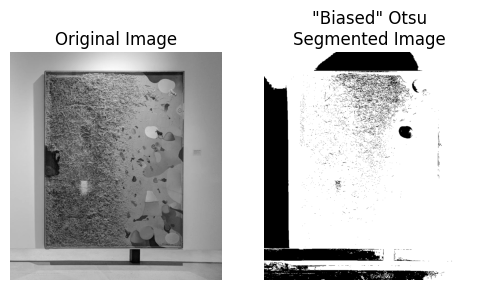

In [27]:
biased_otsu_threshold_masks = []

for img in gray_images[:4]:

    otsu_segmented = biased_otsu_thresholding(img)

    biased_otsu_threshold_masks.append(otsu_segmented)

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(otsu_segmented, cmap='gray')
    plt.title(f'"Biased" Otsu\nSegmented Image')
    plt.axis('off')

    plt.show()

#### Mean Shift

In [28]:
def mean_shift(img):
    
    shifted = cv2.pyrMeanShiftFiltering(img, sp=21, sr=51)

    gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binary_mask_inv = cv2.bitwise_not(binary_mask)

    return binary_mask_inv

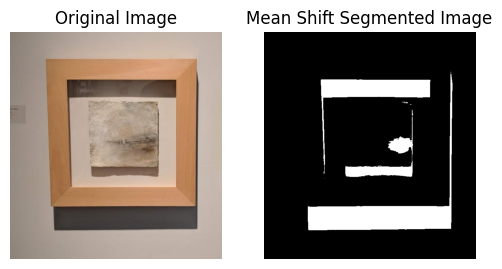

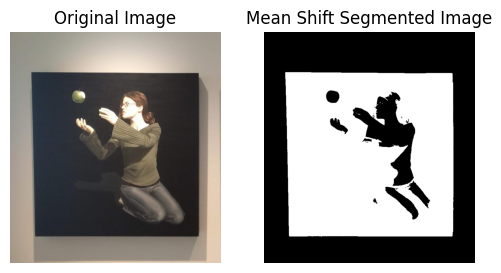

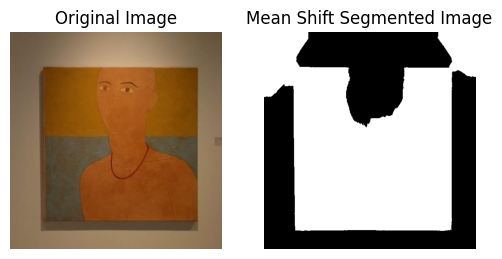

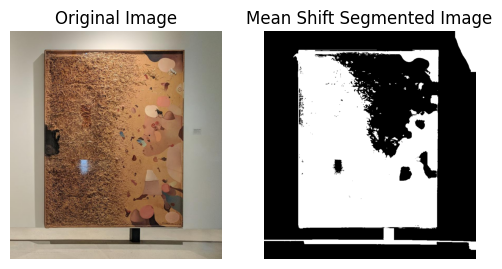

In [29]:
mean_shift_masks = []

for img in rgb_images[:4]:

    mean_shift_masks.append(mean_shift(img))

    plt.figure(figsize=(6, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mean_shift_masks[-1], cmap='gray')
    plt.title('Mean Shift Segmented Image')
    plt.axis('off')

    plt.show()

#### Post processing

Closing and morphological reconstruction

In [30]:
gt_masks = []
color_space='GRAY'
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = change_color_space(img, color_space)
            gt_masks.append(img)

In [31]:
mean_shift_results = {}
mean_shift_results["base_method"] = score_pixel_mask_list(mean_shift_masks, gt_masks)

In [32]:

closing_kernels = [10, 25, 50, 100, 200, 500, 1000]
morph_kernels = [1, 5, 10, 20, 50, 100, 200]

for clos, morph  in itertools.product(closing_kernels, morph_kernels):

    processed_masks = []

    for mask in mean_shift_masks:
        kernel = np.ones((clos, clos), np.uint8)
        binary_mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        marker = cv2.erode(binary_mask_closed, np.ones((morph, morph), np.uint8))
        reconstruction = cv2.dilate(marker, np.ones((morph, morph), np.uint8))
        processed_masks.append(reconstruction)

    mean_shift_results["closing:"+str(clos)+" - morpho:"+str(morph)] = score_pixel_mask_list(processed_masks, gt_masks)

In [33]:
plt.style.use('ggplot')
df = pd.DataFrame.from_dict(mean_shift_results, orient='index', columns=['Precision', 'Sensitivity', 'F1']).reset_index()

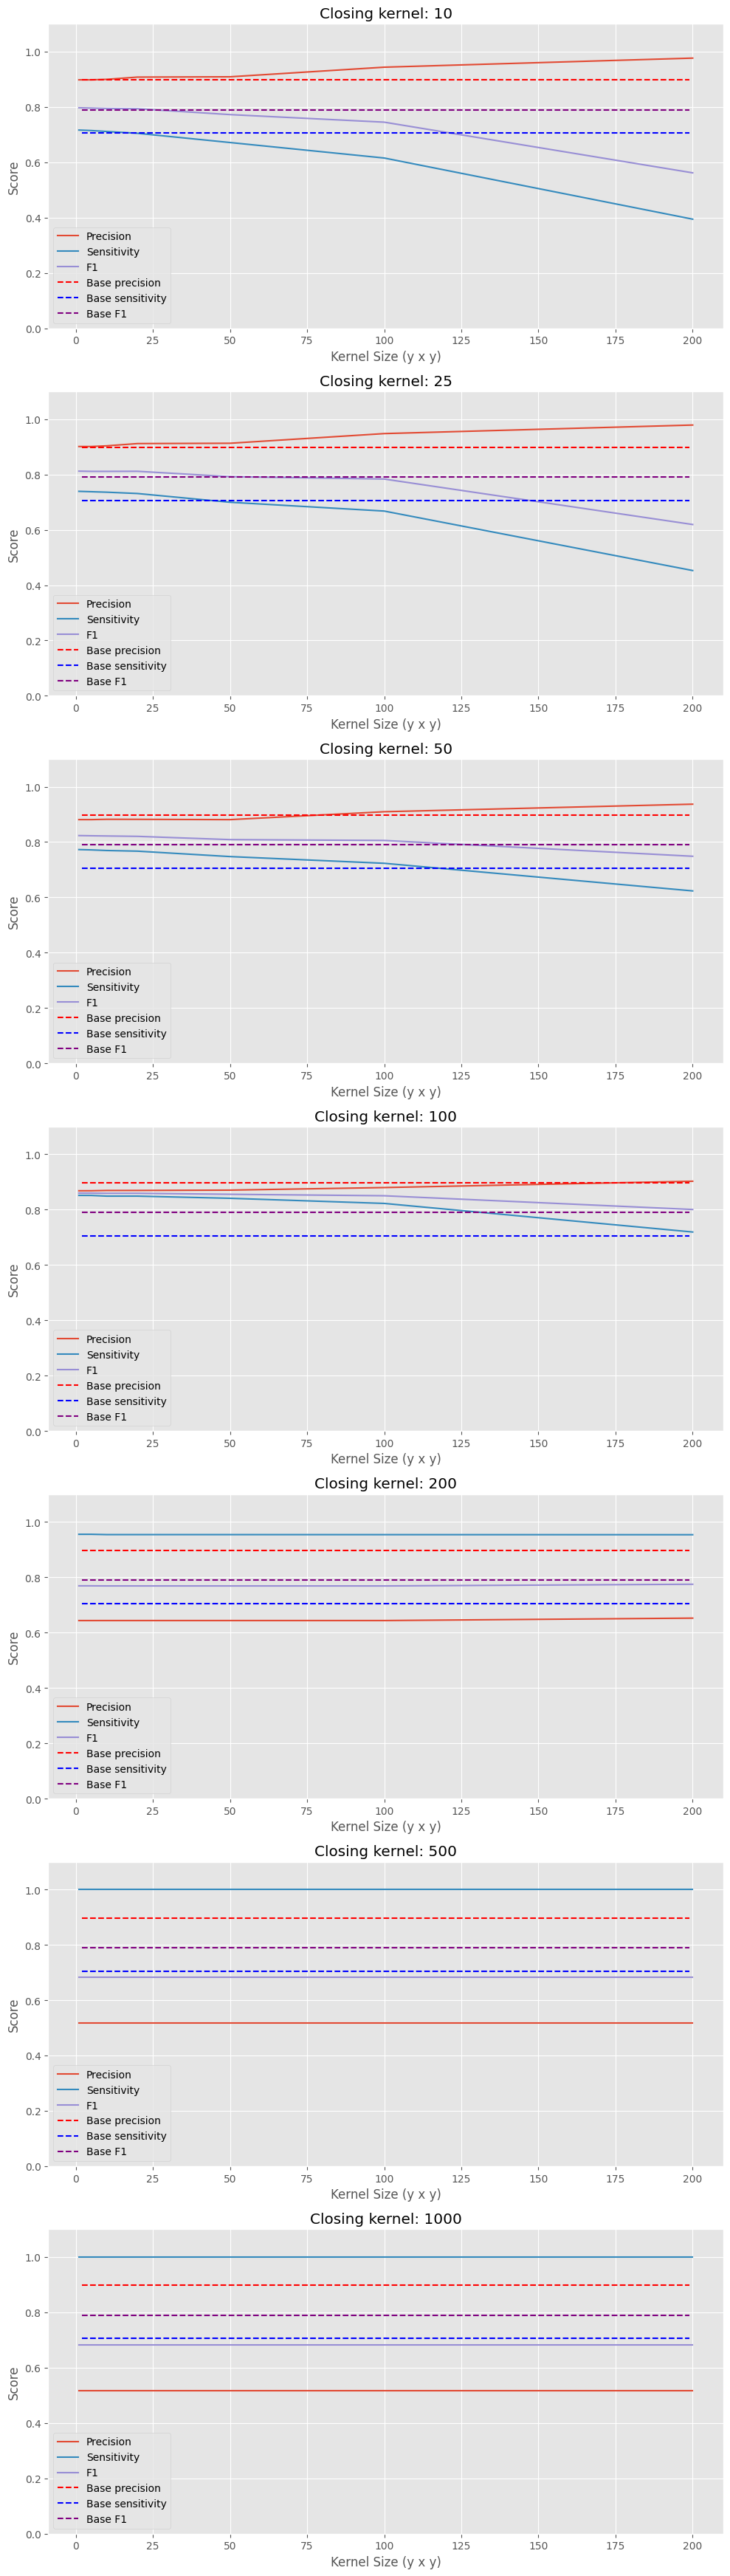

In [34]:
fig, axs = plt.subplots(figsize = (10,35), nrows = len(closing_kernels), ncols=1)
axs = axs.flatten()
for ax, closing in zip(axs, closing_kernels):
    closing_df = df[df["index"].str.contains(f"closing:{closing} ")]
    ax.plot(morph_kernels, closing_df.Precision, label = "Precision")
    ax.plot(morph_kernels, closing_df.Sensitivity, label = "Sensitivity")
    ax.plot(morph_kernels, closing_df.F1, label = "F1")
    ax.axhline(y=df[(df["index"]=="base_method")]["Precision"][0], linestyle="--", label = "Base precision", color='r', xmin=0.05, xmax=0.95)
    ax.axhline(y=df[(df["index"]=="base_method")]["Sensitivity"][0], linestyle="--", label = "Base sensitivity", color='b', xmin=0.05, xmax=0.95)
    ax.axhline(y=df[(df["index"]=="base_method")]["F1"][0], linestyle="--", label = "Base F1", color='purple', xmin=0.05, xmax=0.95)
    ax.set_title(f"Closing kernel: {closing}")
    ax.set_ylim([0,1.1])
    ax.set_xlabel("Kernel Size (y x y)")
    ax.set_ylabel("Score")
    ax.legend(loc="lower left")

plt.tight_layout()
plt.show()

Erosion + Convex Hull

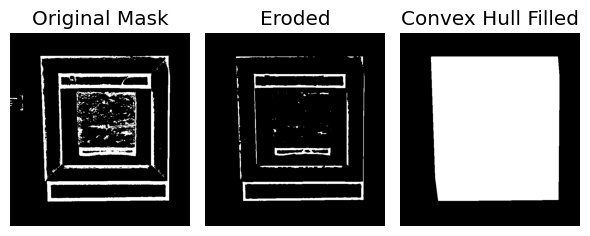

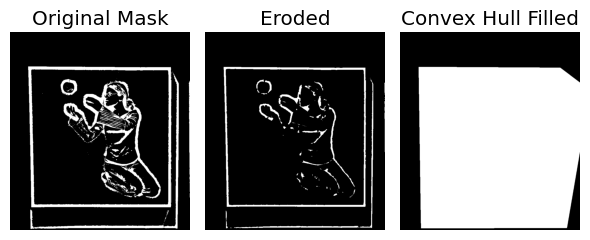

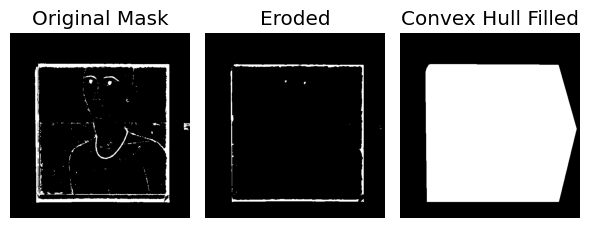

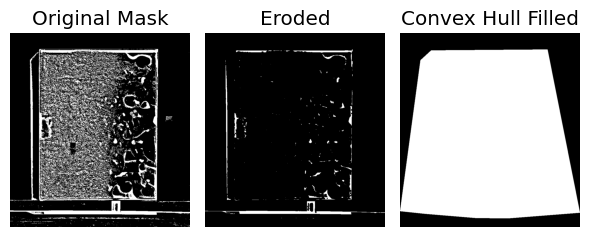

In [35]:
for mask in adaptive_threshold_mean_masks[:4]:

    original_mask = mask

    # Apply opening
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_ERODE, kernel)

    foreground_coords = np.column_stack(np.where(mask)[::-1])

    # Check if there are enough points to form a hull
    if len(foreground_coords) > 2:
        # Compute the convex hull
        hull = ConvexHull(foreground_coords)

        # Create a blank mask to fill the convex hull
        convex_hull_filled = np.zeros_like(mask, dtype=np.uint8)

        # Get the vertices of the convex hull
        hull_points = foreground_coords[hull.vertices]

        # Fill the convex hull on the mask
        cv2.fillConvexPoly(convex_hull_filled, hull_points, 255)
    else:
        convex_hull_filled = np.zeros_like(mask, dtype=np.uint8)

    # Plot the results
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Eroded')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(convex_hull_filled, cmap='gray')
    plt.title('Convex Hull Filled')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Closing + Largest Contour Filling

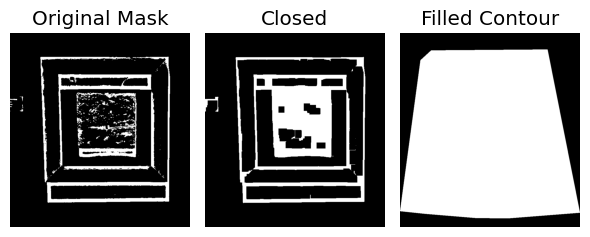

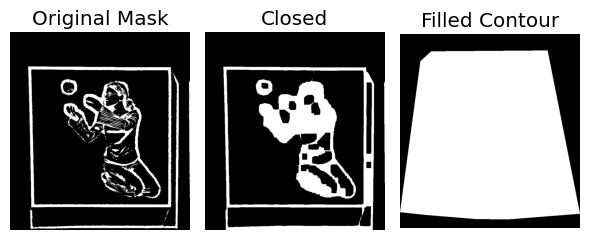

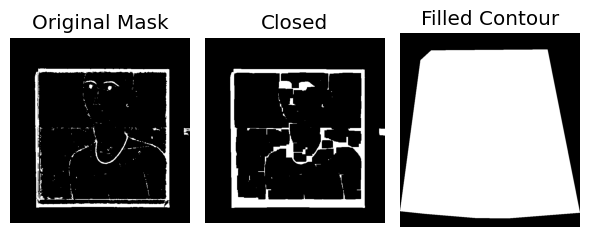

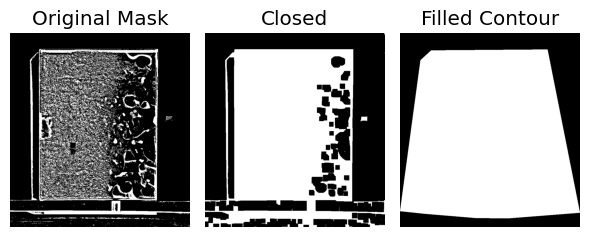

In [36]:
contoured_adaptive_threshold_mean_masks = []

for mask in adaptive_threshold_mean_masks[:4]:

    original_mask = mask

    # Apply opening
    kernel = np.ones((20, 20), np.uint8)

    # Apply closing to fill small gaps
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Fill the largest contour
        largest_contour = max(contours, key=cv2.contourArea)
        filled = np.zeros_like(mask, dtype=np.uint8)
        cv2.drawContours(filled, [largest_contour], -1, 255, thickness=cv2.FILLED)
    else:
        filled = np.zeros_like(mask, dtype=np.uint8)

    contoured_adaptive_threshold_mean_masks.append(filled)

    # Plot the results
    plt.figure(figsize=(6, 3))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_mask, cmap='gray')
    plt.title('Original Mask')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Closed')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(convex_hull_filled, cmap='gray')
    plt.title('Filled Contour')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
